<font size="+3" ><b>Recommender system in Retailrocket dataset<b/></font><br>
    
 <font size="+2"> we apply following AI tecniques on Retail Rocket dataset which has been collected from a real-world ecommerce website<br>
 https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset<br>

<font size="+2">
<b>Steps:</b><br>

1. Preprocessing<br>
2. Pooularity system<br>
3. Content-Based filtering<b>(CBF)</b><br>
4. Content-Based & popularity<br>
5. Collaborative Filtering<b>(CF)</b><br>
6. Hybrid Model(<b>Light FM</b>)
</font>

<font size="+1"> importing the required libraries for data manipulating, visualisation and recommender systems: </font>

In [73]:
# need for hybrid model
!pip install lightfm;;

/bin/bash: -c: line 0: syntax error near unexpected token `;;'
/bin/bash: -c: line 0: `pip install lightfm;;'


In [74]:
# basic library for data manipulation:
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm

 
#visualisation:

%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
from pylab import rcParams
from matplotlib import style
import matplotlib.ticker as tick


#model selection
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


#deep learning libraraies for Collaborative Filtering
import keras
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense , concatenate
from keras.utils.vis_utils import model_to_dot
from keras.layers import Flatten,Input,Embedding,dot
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from IPython.display import SVG ,display, Image

 
#light FM:
from scipy.sparse import coo_matrix 
from lightfm import LightFM
from lightfm.evaluation import auc_score
import pickle

<font size="+3"><b> Preprocessing:</b></font>


<font size="+1">
1. Read events.csv ,item_properties_part1.csv, item_properties_part2.csv files into pandas dataframe.<br>
2. Concatenate item_properties_1 and item_properties_2 dataframes into one dataframe.<br>
3. Filter the items dataframe to only include the rows with 'property'equals to 'categoryid'.<br>
4. Merge the item_df with events on 'itemid' column.<br>
5. Convert the 'value' column of df1 to int datatype.<br>
6. Rename the 'value' column to 'categoryid', drop 'timestamp' and 'transactionid' columns.<br>
</font>

##  run cell bellow if you are on google colab otherwise uncomment the next cell if using Kaggle:

In [106]:
fname = "dataset.zip"
!gdown  https://drive.google.com/uc?id=15yIQN-bcbiIAKT_I84RkuRP-Yq_UmfRb -O {fname}
!unzip -o {fname}


event_dir= '/content/dataset/events.csv'
item1_dir = '/content/dataset/item_properties_part1.csv'
item2_dir= '/content/dataset/item_properties_part2.csv'

event = pd.read_csv(event_dir)
item_properties_1 = pd.read_csv(item1_dir)
item_properties_2 = pd.read_csv(item2_dir)

Downloading...
From: https://drive.google.com/uc?id=15yIQN-bcbiIAKT_I84RkuRP-Yq_UmfRb
To: /content/dataset.zip
100% 305M/305M [00:03<00:00, 80.5MB/s]
Archive:  dataset.zip
  inflating: dataset/events.csv      
  inflating: dataset/item_properties_part1.csv  
  inflating: dataset/item_properties_part2.csv  


In [76]:
# uncomment this if using kaggle:

#event = pd.read_csv('/kaggle/input/ecommerce-dataset/events.csv')
#item_properties_1 = pd.read_csv("/kaggle/input/ecommerce-dataset/item_properties_part1.csv")
#item_properties_2 = pd.read_csv("/kaggle/input/ecommerce-dataset/item_properties_part2.csv")


In [77]:
items = pd.concat([item_properties_1, item_properties_2])
events = event.copy()
print(len(event))


item_df = items[items['property'] == 'categoryid']
df1 = events.merge(item_df[['itemid', 'value']], on='itemid')
df1['value'] = df1['value'].astype(int)
df1.rename(columns={'value':'categoryid'}, inplace=True)
df1 = df1.drop(columns=['timestamp', 'transactionid'])
df1.head()



2756101


,visitorid,event,itemid,categoryid
0,257597,view,355908,1173
1,981382,view,355908,1173
2,979686,view,355908,1173
3,479732,view,355908,1173
4,397425,view,355908,1173


<font size="+1">
* every row in data consider as a interaction which has been done by a visitor.<br>
* we define a function named **interaction_filterd** to filter our data based on user interactions.<br>
* we will use it in our methods frequently and play an important part in the result.<br>
    
<br>
* we also should enumerate our interactions with a number which show the contribution of users, to do that we define function "**get_rating**".<br>
 (i.e: get_rating(1,2,3) means our view , add to cart and transaction are 1,2,3 respectively)
</font>

In [78]:
# every row in data consider as a interaction which has been done by a visitor
# function below filter the visitor based on the number of their interaction

def interaction_filter(n_interaction):
    user_value_counts = df1['visitorid'].value_counts()
    df = df1[df1['visitorid'].isin(user_value_counts[user_value_counts >=n_interaction].index)]
    return df


# create a function to converte events into a numerical rating value 
def get_rating(a, b, c):
    def rating(x):
        for e in x:
            if e == 'view':          return a
            elif e == 'addtocart':   return b
            elif e == 'transaction': return c
        return 0
    return rating

In [79]:
number_of_all_events= len(events)
number_of_views= len(events[events['event']== "view"])
number_of_add_to_cart= len(events[events['event']== "addtocart"])
number_of_transactions= len(events[events['event']== "transaction"])
number_of_unique_items = len(events['itemid'].unique())
number_of_unique_visitors = len(events['visitorid'].unique())
number_of_visitors_with_one = len(df1) - len(interaction_filter(2))


print(f"number of all events: {number_of_all_events}")
print(f"views: {number_of_views}")
print(f"add to carts: {number_of_add_to_cart}")
print(f"transactions: {number_of_transactions} \n")
print(f"number of unique items: {number_of_unique_items}")
print(f"number of unique visitors: {number_of_unique_visitors}")
print(f"number of visitors with only 1 interaction : {number_of_visitors_with_one}")


number of all events: 2756101
views: 2664312
add to carts: 69332
transactions: 22457 

number of unique items: 235061
number of unique visitors: 1407580
number of visitors with only 1 interaction : 788782


<font size="+1">
Number of all events: <b>2756101</b><br>
Views: <b>2664312</b><br>
Add to carts: <b>69332</b><br>
Transactions: <b>22457</b><br>
<br>
Number of unique items: <b>235061</b><br>
Number of unique visitors: <b>1407580</b><br>
Number of visitors with only 1 interaction: <b>788782</b><br>
The data reveals that visitors with only one interaction account for almost <b>28%</b> of all visitors.
</font>

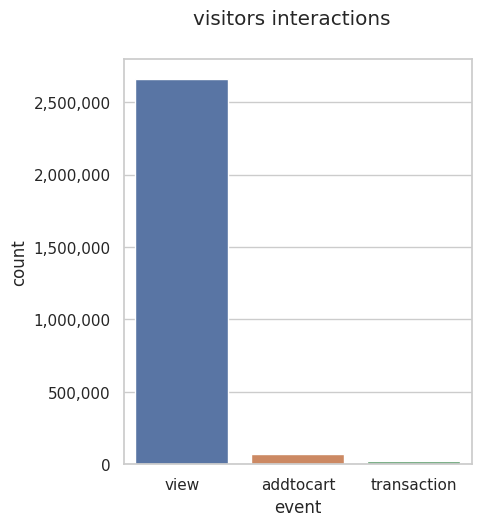

In [80]:
# plot the events contents

# this function used in Seaborn to customize the formatting of tick labels 
def f(value, tick_number):
    return '{:,.0f}'.format(value)


colors = ['red', 'limegreen', 'dodgerblue']


plt.figure(figsize=(4,5))
bar= sns.countplot(x='event', data=events)
plt.suptitle('visitors interactions')
bar.yaxis.set_major_formatter(tick.FuncFormatter(f))
plt.show()

<font size="+3"><b> Pooularity system:</b>

In [81]:
# create a weight column using numerical value of event column

df= df1.copy()
rating = get_rating(0.01, 0.1, 1)
df['weight'] = df.apply(rating, axis=1)

In [82]:
#function below get the dataframe and return most interacted item in each category 
def get_weight(df):
    group = df.groupby(['categoryid', 'itemid'], as_index=False)    
    return group.agg({'weight': 'sum'}).sort_values(by=['categoryid', 'weight'], ascending=[True, False])

<font size="+2">Return Top Item of a Random Category:</font>

<font size="+1">
<b>Steps:</b><br>
1. Get a random category ID from the dataset using the `sample` function.<br>
2. Get all of the items belonging to the chosen category ID.<br>
3. Group the items in a DataFrame based on their item ID and sum their weights.<br>
4. Sort them in a descending way and create a new DataFrame named `top_items` which only includes the top 5 items.<br>
</font>

In [83]:
# function below 

def get_top_weighted_items_for_random_gategoryID(df):
    category_id = df['categoryid'].sample(n=1, random_state=42).values[0]
    items = df[df['categoryid'] == category_id]
    item_weights = items.groupby('itemid', as_index=False)['weight'].sum()
    top_items = item_weights.sort_values('weight', ascending=False).head(5)
    print(f" most popular items for category: {category_id} are:")
    return top_items, category_id


top_items,category_id = get_top_weighted_items_for_random_gategoryID(df)
top_items

 most popular items for category: 381 are:


,itemid,weight
83,129279,18.76
137,210846,17.88
66,98012,14.22
1,3902,10.44
2,5206,9.96


<font size="+1"> 1.  convert the weight and item id to list<br> 1. plot them:</font>

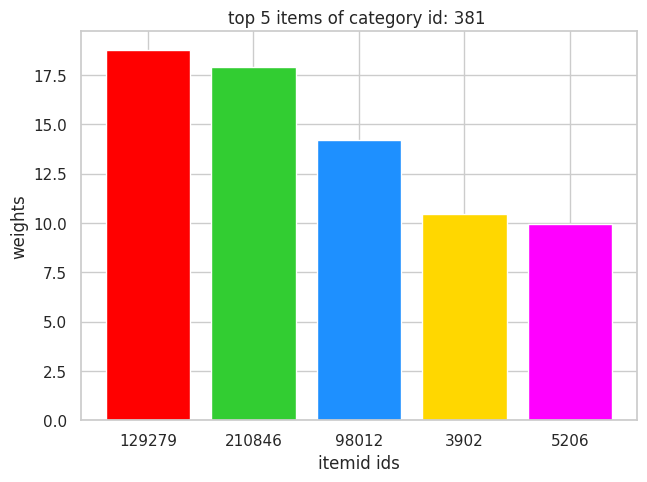

In [84]:
weight = top_items['weight'].tolist()
itemid = top_items['itemid'].tolist()
itemid =[str(item) for item in itemid]


colors = ['red', 'limegreen', 'dodgerblue', 'gold', 'fuchsia']
plt.bar(itemid, weight, color=colors)

# set title and axis labels
plt.title(f'top 5 items of category id: {category_id} ')
plt.xlabel('itemid ids')
plt.ylabel('weights')
plt.show()

<font size="+3"><b> Content-Based filtering:</b>

<font size="+1">
Content-based Filtering is a recommender system which make recommendaation based on similarity between items.<br>

The cosine similarity between the item vectors is then calculated by dividing the vectors' dot products by their norm of vectors.
</font>

![image.png](attachment:6f14a5df-24eb-4433-9a7e-3a67d930f396.png)

<font size="+3">CB_model:</font>

<font size="+1">
<b>Steps:</b><br>
1. apply interaction_filter to keep users with required interaction minimum and drop duplicate items<br>
2. due to matix limitation select a raction of the total rows to have a smaller size.<br>
3. groupthe  categories and creating a series where each category has a list of its items a list.<br>
4. Create a cooccurrence matrix and for each pair of category and item set the value to 1 if item belongs to th category, otherwise set to 0.<br>
5. calculate the similarity between all pairs of items by applying cosine similarity on cooccurrence matrix.<br> 
</font>

<font size="+3">evaluate CB by calculating percision and recall:</font>

<font size="+1">
<b>Steps:</b><br>
1. apply a for loop for each unique user<br>
2. computes the most frequently interacted item for each user.<br>
3. find the similar items using cosine similarity <br>
4. select the top 100 items and put them in recommended_items<br>
5. create a list of user_items that the selected user has interacted with<br>
6. create list of correct_items which include items that are common in both user_items and recommended_items <br>
7. for <b> Recall </b> calculating the accuracy by dividing size of correct_items by size of user_items for each user and get the average.<br>
8. for <b> precision </b> calculating the percision by dividing size of correct_items by size of recommended_items for each user and get the average.<br>
</font>

In [85]:
def CB_model(n_interaction, frac):
    dataCB = interaction_filter(n_interaction)
    dataCB = dataCB.drop_duplicates(subset='itemid', keep='first')
    dataCB = dataCB.sample(frac= frac)
    item_category = dataCB.groupby('categoryid')['itemid'].apply(list)
    item_cooccurrence = item_category.apply(lambda x: pd.Series(1, index=x)).fillna(0)
    item_similarity = cosine_similarity(item_cooccurrence.T)
    return item_similarity,item_cooccurrence ,dataCB

def evaluate_CB():
    users_u = dataCB.visitorid.unique()
   
    accuracies = []
    precisions = []


    
    for user in users_u:
        user_data = dataCB[dataCB['visitorid'] == user]
        item_counts = user_data.groupby('itemid').size()
        most_interacted_item = item_counts.sort_values(ascending=False).index[0]
        col_num = item_cooccurrence.columns.get_loc(most_interacted_item)
        similar_scores = item_similarity[col_num]
        similar_items = np.argpartition(-similar_scores, 100)[1:101]
        recommended_items = item_cooccurrence.columns[similar_items]

        user_items = dataCB[dataCB['visitorid'] == user]['itemid']
        correct_items = [item for item in recommended_items if item in user_items]
        
        #recall for this user
        accuracy = len(correct_items) / len(user_data)
        accuracies.append(accuracy)

        #percision for this user
        precision = len(correct_items) / len(recommended_items)
        precisions.append(precision)
        
    avg_recall = 100* sum(accuracies) / len(accuracies)
    avg_precision = 100*sum(precisions) / len(precisions)
    
    print(f"CB precision across all users: {avg_precision:.2f}% ")
    print(f"CB recall across all users: {avg_recall:.2f}% ")
    #print(users_ids)


<font size="+2">get top 5 similar items for a random user:<br> </font><br>

<font size="+1">
* in the following cell we create a list of unique user ids<br>
* randomely choose a user_id<br>
* selects all items interacted  by the randomly selected user<br>
* select item that the user interacted with the most after sorting them in a descending order<br>
* find the column index of that item in the item_cooccurrence matrix<br>
* get the similarity scores of that item with other items<br>
* get the indexes of the top 5 items that have the highest similarity to that item<br>
* finds the top 5 column names in the item_cooccurrence matrix and print them<br>
    
 </font>

In [86]:
item_similarity ,item_cooccurrence , dataCB = CB_model(n_interaction=300, frac=0.4)

users_u = dataCB.visitorid.unique()                            
selected_user = np.random.choice(users_u)
user_data = dataCB[dataCB['visitorid'] == selected_user]
item_counts = user_data.groupby('itemid').size()
most_interacted_item = item_counts.sort_values(ascending=False).index[0]
col_num = item_cooccurrence.columns.get_loc(most_interacted_item)
similar_scores = item_similarity[col_num]
similar_items_indices = np.argpartition(-similar_scores, 5)[1:6]
similar_items = item_cooccurrence.columns[similar_items_indices]
print(f"top 5 similar items to user {selected_user} are:   {similar_items}")

top 5 similar items to user 962131 are:   Int64Index([285152, 391865, 333023, 234494, 73760], dtype='int64')


<font size="+1">in the following cell, we are only using half of the users who have more than 300 interactions:<br>
because cosine similarity is limited and we cannot utilize all of our records.<br>
<b>This issue leads to an unreasonable precision and recall which is not accepted:</b><br>
this happened because we have to drop a large fraction of our dataset and our items in this dataset only have on column as a featuer which is not enough,<br>
However we will solve this by using DL.
 
</font>
    

In [87]:
# so it is apparent that without using deep learning recall and percision is almost 0.

#CB_model(n_interaction=300, frac=0.5)

CB_model(n_interaction=100, frac=0.2)
evaluate_CB()

CB precision across all users: 0.00% 
CB recall across all users: 0.00% 


<font size="+3"><b> CB & Populariy-based:</b>
    
<font size="+1">
in the following cell I created a function which is a combination of CB and popularity system.<br>

Although this approach might already exist in papers,I came up with it and wanted to share the results with you. <br>
Nonetheless, it did give accuracy or recall and is not comparable at all with other approaches  .<br>
    

as you know:<br>
<b>CB:</b> find similarity between items based on there feature and recommend it to user<br>
<b>popularity:</b> filter the top interacted items and recommend them <br>

<font size="+1">
<b>Steps:</b><br>
1. get a random visitor id<br>
2. keep this user and filter other ones <br>
3. get the top 5 category id that this user had the most interaction with<br>
4. create a new datafraim named:top_items_df with these columns=['visitorid', 'categoryid', 'item_recommended', 'weight']<br>
5. for each top 5 category id we filters the main dataframe to include only rows that have'categoryid.<br>
6. groups the data by 'itemid' calculating the sum of the 'weight'<br>
6. Sort them in descending order and recommend the top 5 <br>
</font>


In [88]:
def get_top_weighted_items_for_random_visitor(df):
    visitor_id = random_visitor_id = datan['visitorid'].sample().iloc[0]
    visitor_data = df[df['visitorid'] == visitor_id]
    category_counts = visitor_data['categoryid'].value_counts().head(5)

    top_items_df = pd.DataFrame(columns=['visitorid', 'categoryid', 'item_recommended', 'weight'])


    for category_id in category_counts.index:
        c_data = df[df['categoryid'] == category_id]
        item_weights = c_data.groupby('itemid', as_index=False)['weight'].sum()
        top_item = item_weights.sort_values('weight', ascending=False).iloc[0]
        top_items_df.loc[len(top_items_df)] = [visitor_id, category_id, top_item['itemid'], top_item['weight']]
    
    return top_items_df

datan = interaction_filter(n_interaction= 100)
len(datan)

get_top_weighted_items_for_random_visitor(df)

,visitorid,categoryid,item_recommended,weight
0,737053.0,396.0,122585.0,10.72
1,737053.0,716.0,456276.0,6.50
2,737053.0,558.0,444888.0,20.02
3,737053.0,317.0,62275.0,11.08
4,737053.0,707.0,320130.0,1027.31


<font size="+3"><b> Collaborative Filtering:</b><br>

  <font size="+1">we use MAtrix Factorisation(MF) approach which is a method of CF to train our deep learning model for item-user rating:</font>
    
![image.png](attachment:777b51b8-929e-4233-bd34-b795c18b925b.png)!
    
<font size="+1">
<b>CF model:</b><br>
1. Clear previous Keras session ,Filter interactions<br> 
2. Group data by visitorids, itemids, and categoryisd and get the rating for each group<br>
3. Get the number of unique visitors and items and Create lists of unique for each one<br>
4. map visitors and items to their index values and replace them with their index values<br>
5. Split data into train and test sets<br>
6. Define an input layer for items and visitors embeddings <br>
7. Create item and visitor embeddings, specify the number of latent Factors, Flatten them<br>
8. Calculate dot product between visitor and item vectors<br>
9. Define the model and compiling the neural network model with a optimizer and loss function.<br>
10. Train the model using the training data with  batch size, num of epochs, val_data, and verbosity.<br>
11. Calculate the root mean squared error (RMSE) for accuracy by prediction <br>
<br><br>
<b>ploting_loss:</b><br>  
Plot the train and test loss with the number of interactions, RMSE, and final validation loss.<br></font>

In [89]:
def cf_model(df1,n_interaction, batch_size, epochs,n_latent_factors, verbose, rating, optimizer):
    tf.keras.backend.clear_session()
    df1= interaction_filter(n_interaction)
    n_interaction =n_interaction
    data= df1.copy()
    data = data.groupby(by=['visitorid', 'itemid','categoryid'])['event'].agg([rating]).reset_index()

    
    n_visitors = len(data['visitorid'].unique())
    n_items = len(data['itemid'].unique())
    
    # create list of unique visitors and items
    visitors = data['visitorid'].unique()
    items = data.itemid.unique()

    # create dictionary for visitor and items with their indexes which are position of that element
    visitor_dic = {v:idx for idx,v in enumerate(visitors)}
    item_dic = {v:idx for idx,v in enumerate(items)}
    
    #replace visitors and items with their corresponding index values
    data['visitorid'] = data['visitorid'].apply(lambda x: visitor_dic[x])
    data['itemid'] = data['itemid'].apply(lambda x: item_dic[x])
    
    # split the data into two part  
    train, test = train_test_split(data, test_size=0.20, random_state=42)

    # item Embeddings
    item_input = Input(shape=(1,), name='item_Input')
    item_embeddings = Embedding(n_items, n_latent_factors, input_length=1, name='item_Embedding')(item_input)
    item_vector = Flatten(name='item_Vector')(item_embeddings)
    
    # visitor Embeddings
    visitor_input = Input(shape=(1,), name='Movie_Input')
    visitor_embeddings = Embedding(n_visitors, n_latent_factors, input_length=1, name='visitor_embedding')(visitor_input)
    visitor_vector = Flatten(name='visitor_Vector')(visitor_embeddings)
    
    # dot Product 
    Dot_Product = dot([visitor_vector, item_vector], name='Dot_Product', axes=1)
    model = Model([visitor_input, item_input], Dot_Product)
    
    # configure the learning process of a neural network model in Keras using Adam, adgard or RMSEprop optimizer
    model.compile(optimizer=optimizer, loss='mse')
    

    # This line of code trains the compiled neural network model using the training data, with a specified batch size, number of epochs, validation data, and verbosity level.
    History = model.fit([train.visitorid,train.itemid],train.rating, batch_size=batch_size,
    epochs =epochs, validation_data = ([test.visitorid,test.itemid],test.rating),verbose =verbose)
    
    # calculate the mean squared error for accuracy
    mse = mean_squared_error
    test_pred = model.predict([test.visitorid, test.itemid])
    RMSE = np.sqrt(mse(test_pred, test.rating))
    print("RMSE: %.3f\n"%RMSE)
    #print(len(data))
    return RMSE, History, model, test ,n_interaction



# plotting the training and test loss
def ploting_loss(History, n_interaction, RMSE):
    rcParams['figure.figsize'] = 5, 3
    plt.plot(History.history['loss'], 'g')
    plt.plot(History.history['val_loss'], 'b')
    last_val_loss = History.history['val_loss'][-1]
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title(f"n_interaction: {n_interaction}, RMSE: {RMSE:.2f},  Final val_loss: {last_val_loss:.3f}")
    #plt.title(f"n_interactions: {n_interaction}, RMSE : {RMSE:.2f} ,Final val_loss: {last_val_loss:.3f}")
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.show()

In [90]:

rating = get_rating( 1,2,3)
#rating = get_rating( 0.01,0.1, 1)
RMSE, History, model ,test ,n_interaction = cf_model(df1,n_interaction= 500 ,batch_size=1024,epochs=20,
                                                        n_latent_factors=65,  verbose=1,rating= rating ,optimizer=Adagrad(learning_rate=12) )

Epoch 1/20
59/59 [==============================] - 1s 9ms/step - loss: 1.2441 - val_loss: 1.0688
Epoch 2/20
59/59 [==============================] - 0s 7ms/step - loss: 0.6681 - val_loss: 0.5589
Epoch 3/20
59/59 [==============================] - 1s 11ms/step - loss: 0.1771 - val_loss: 0.4690
Epoch 4/20
59/59 [==============================] - 1s 9ms/step - loss: 0.0535 - val_loss: 0.4467
Epoch 5/20
59/59 [==============================] - 0s 5ms/step - loss: 0.0205 - val_loss: 0.4415
Epoch 6/20
59/59 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.4392
Epoch 7/20
59/59 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.4382
Epoch 8/20
59/59 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.4379
Epoch 9/20
59/59 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.4377
Epoch 10/20
59/59 [==============================] - 0s 6ms/step - loss: 8.6582e-04 - val_loss: 0.4373
Epoch 11/20
59

<font size="+2"><b> Comoparing optimizers:</b><br>

  <font size="+1">to evaluate the performance of optimizers we plot them at number of interaction = 500</font>
    
    
<font size="+1">
1. Create optimizer list<br> 
2. Create a figure with subplots for each optimizer<br>
3. run the collaborative filtering model<br>
4. Plot the loss for each optimizer<br>

472/472 [==============================] - 1s 1ms/step
RMSE: 0.657

472/472 [==============================] - 1s 1ms/step
RMSE: 0.772

472/472 [==============================] - 1s 1ms/step
RMSE: 0.800



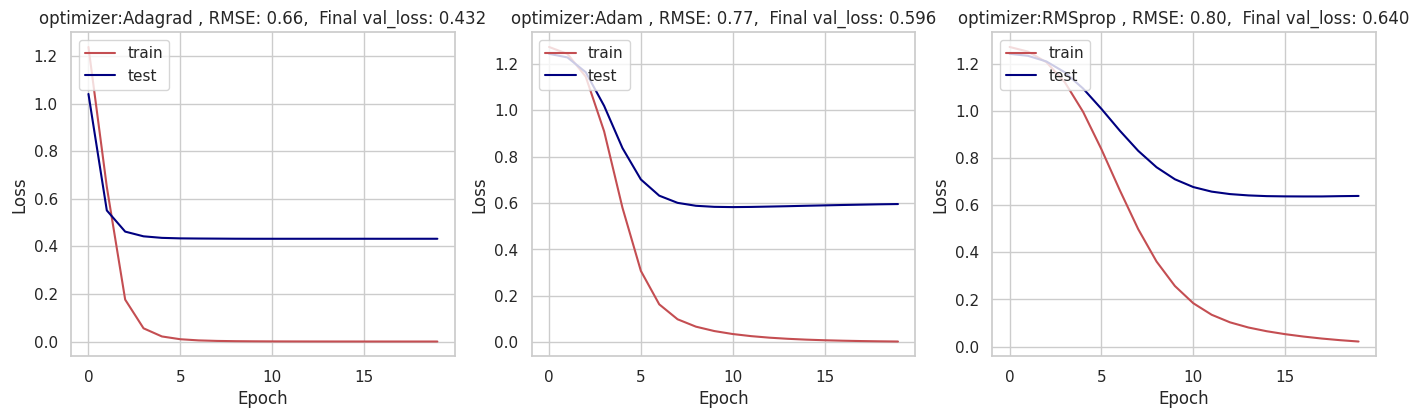

In [91]:
optimizers = [Adagrad(learning_rate=12), Adam(learning_rate=1e-3), RMSprop(learning_rate=1e-3)]

def o_ploting_loss(History, n_interaction, RMSE, ax):
    ax.plot(History.history['loss'], 'r')
    ax.plot(History.history['val_loss'], 'navy')
    last_val_loss = History.history['val_loss'][-1]
    ax.set_title('Model Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_title(f"optimizer:{type(optimizer).__name__} , RMSE: {RMSE:.2f},  Final val_loss: {last_val_loss:.3f}")
    ax.legend(['train', 'test'], loc='upper left')
    ax.grid(True)
fig, axs = plt.subplots(1, len(optimizers), figsize=(15,4))




for ax, optimizer in zip(axs.flatten(), optimizers):
    RMSE, History, model ,_,n_interaction = cf_model(df1,n_interaction= 500 ,batch_size=1024,epochs=20,n_latent_factors=65,  verbose=0,rating= rating ,optimizer= optimizer)
    o_ploting_loss(History, n_interaction, RMSE, ax)


<font size="+2"><b> view the deep learning model in the form of a Scalable Vector Graphics (SVG):</b>


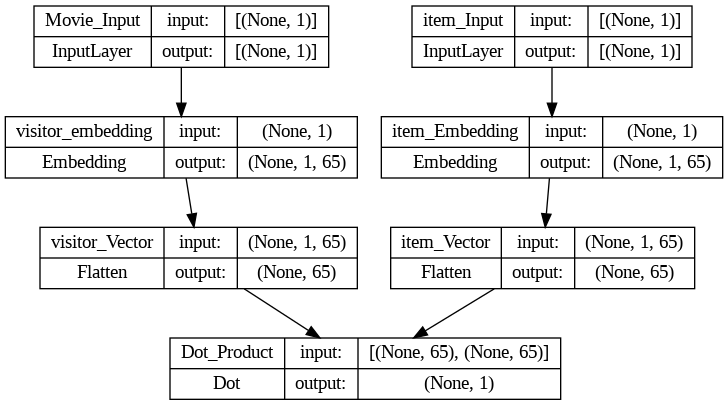

In [92]:
#  view the deep learning model in the form of a Scalable Vector Graphics (SVG)

svg = model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='png')
display(Image(svg))

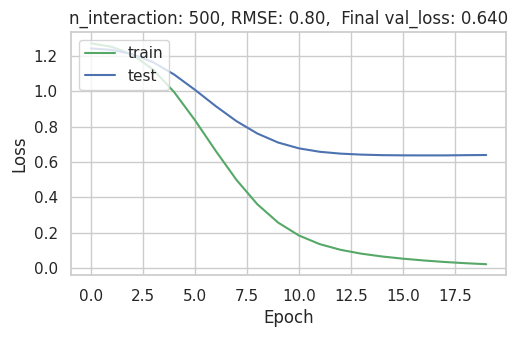

In [93]:
ploting_loss(History, n_interaction, RMSE)

<font size="+1">
to get better result for recall and percision we change the rating values of view,add_to_cart,transaction from  1,2,3   to   0.01, 0.1, 1<br>
and run the model again:

In [94]:
# these values for events give us higher recall and percision, indicates that accuracy of mse is not reliable
rating = get_rating(0.01, 0.1, 1)

# by changing n_interaction you can see the impact of historical information
RMSE, History, model, test ,n_interaction = cf_model(df1,n_interaction= 500 ,batch_size=1024,epochs=20,
                                                        n_latent_factors=65,  verbose=1,rating= rating ,optimizer=Adam(learning_rate=1e-3) )

Epoch 1/20
59/59 [==============================] - 3s 34ms/step - loss: 0.0220 - val_loss: 0.0190
Epoch 2/20
59/59 [==============================] - 2s 38ms/step - loss: 0.0213 - val_loss: 0.0189
Epoch 3/20
59/59 [==============================] - 2s 28ms/step - loss: 0.0201 - val_loss: 0.0188
Epoch 4/20
59/59 [==============================] - 2s 34ms/step - loss: 0.0179 - val_loss: 0.0187
Epoch 5/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0145 - val_loss: 0.0185
Epoch 6/20
59/59 [==============================] - 2s 28ms/step - loss: 0.0106 - val_loss: 0.0186
Epoch 7/20
59/59 [==============================] - 3s 56ms/step - loss: 0.0076 - val_loss: 0.0186
Epoch 8/20
59/59 [==============================] - 3s 43ms/step - loss: 0.0054 - val_loss: 0.0187
Epoch 9/20
59/59 [==============================] - 2s 35ms/step - loss: 0.0037 - val_loss: 0.0188
Epoch 10/20
59/59 [==============================] - 2s 35ms/step - loss: 0.0024 - val_loss: 0.0189
Epoch 11/

<font size="+2"><b>evaluate_CF:</b><br>
 this evslustor claculate Recall and percision for the users of given size<br></font>
<br>
<font size="+1">1. get unique visitors in test data and randomly select users of given size.<br>
2. Loop across each user in the selected users and extract items interacted by the user.<br>
3. Make predictions for all extracted items and sort them based on their ratings in descending order.<br>
4. Select the top n recommended items.<br>
5. caculate the percision and recall like what we have done in CBF evaluater.<br>
</font>

In [95]:
def evaluate_CF(user_size, n_recom_items):
    users_u = test.visitorid.unique()
    users = np.random.choice(users_u, user_size)    
    accuracies = []
    precisions = []

    
    
    for user in users:
        user_items = test[test.visitorid == user].itemid.tolist()
        item_ratings = model.predict([np.array([user] * len(test['itemid'])), test['itemid']],verbose=0)
        sorted_items = [x for _,x in sorted(zip(item_ratings, test['itemid']), reverse=True)]
        recommended_items = sorted_items[:n_recom_items]

        # calculate recall:
        correct_items = [item for item in recommended_items if item in user_items]
        accuracy = len(correct_items) / len(user_items)
        accuracies.append(accuracy)

        # calculate precision:
        relevant_items = [item for item in recommended_items if item in user_items]
        precision = len(relevant_items) / len(recommended_items)
        precisions.append(precision)

    avg_recall = 100* sum(accuracies) / len(accuracies)
    avg_precision = 100*sum(precisions) / len(precisions)
    #F1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
    
    #n_interaction =n_interaction
    print(f"CF precision across {user_size} users: {avg_precision:.2f}% ")
    print(f"CF recall across {user_size} users: {avg_recall:.2f}% ")
    #print(f"CF F1-score : {F1_score:.4f} ")

<font size="+1"> recall and percision will be increase by changing number of interactions:

In [96]:
# change the parameter:n_interaction in the cf_model we can test the model 
evaluate_CF(user_size=20, n_recom_items=100)

CF precision across 20 users: 3.90% 
CF recall across 20 users: 3.94% 


<font size="+3"><b> Hybrid model(light FM):</b><br>


  <font size="+1">we use Light FM model which is  Hybrid recommender ystem,<br>
      The LightFM model's structure is almost similar to that of matrix factorization, with some differences.<br>
      this model outperforms others in cold-starts  :</font>
    
![image.png](attachment:abcf9e0d-44de-493c-9fb7-072f640d168c.png)!
    
<font size="+1">
<b>Light_model:</b><br>
1. Filter data based on number of interaction.<br>
2. Group data by visitorids, itemids, and categoryisd and get the rating for each group<br>
3. Get the number of unique visitors and items and Create lists of unique for each one<br>
4. Map vitors and items to their index values and replace them with their index values.<br>
5. Split data into train and test sets.<br>
6. Create the sparse matrices for the train and test sets.<br>
7. fine a `LightFM` model with the given number of components.<br>
8. Fit the model on the train data <br>
9. calculate the accuracy on the test data.<br>
<br>
In COO matrix(sparse) the rows and columns  correspond to the visitors and items, the values correspond to the rating, rest of them set to zero.    
</font>


In [97]:
def Light_model(df1, n_interaction, no_components, epochs):
    df1= interaction_filter(n_interaction)
    data= df1.copy()
    data = data.groupby(by=['visitorid', 'itemid','categoryid'])['event'].agg([rating]).reset_index()  
    n_visitors = len(data['visitorid'].unique())
    n_items = len(data['itemid'].unique())
    visitors = data['visitorid'].unique()
    items = data.itemid.unique()
    
    visitor_dic = {v:idx for idx,v in enumerate(visitors)}
    item_dic = {v:idx for idx,v in enumerate(items)}
    data['visitorid'] = data['visitorid'].apply(lambda x: visitor_dic[x])
    data['itemid'] = data['itemid'].apply(lambda x: item_dic[x])
    
    train, test_ = train_test_split(data, test_size=0.20, random_state=42)

    matrix=dict()
    matrix['train']=coo_matrix((train['rating'],(train['visitorid'], train['itemid'])) ,shape=(n_visitors,n_items))
    matrix['test']=coo_matrix((test_['rating'],(test_['visitorid'], test_['itemid'])) ,shape=(n_visitors,n_items))

    light_model=LightFM(no_components =no_components ,loss='warp')
    light_model.fit(matrix['train'],epochs=epochs,num_threads=4)
    ac_test = auc_score(light_model, matrix['test']).mean()
    

    print("Test AUC: %.3f\n"%ac_test)
    return light_model, matrix, data, test_

In [98]:
light_model, matrix, data, test_ = Light_model(df1, n_interaction=500, no_components=5,epochs=100)

Test AUC: 0.723



In [99]:
# in the cell below we randomly choose a user and recommend him/her top 5 personalized items from test-data

test_users = np.unique(matrix['test'].row)
test_items = np.unique(matrix['test'].col)


selected_user = np.random.choice(test_users)
scores = light_model.predict(np.array([selected_user] *len(test_items)) ,test_items)

recommend_item = []

top_items = data['itemid'][np.argsort(-scores)].tolist()
recommend_item.append(top_items[:5])
print('For user: %s lightFM recommends: %s' % (selected_user, recommend_item))

For user: 28 lightFM recommends: [[195, 2132, 2294, 2276, 692]]


<font size="+1">The LightFM evaluator works in the same way as Collaborative Filtering evaluator:

In [100]:
def evaluate_lightFM(user_size, n_recom_items):

    accuracies = []
    precisions = []

    for user in range(user_size):
        selected_user = np.random.choice(test_users)
        user_items = test_[test_.visitorid == selected_user].itemid.tolist()
        
        
        #item_ratings = light_model.predict(np.array([user] * test_items), test_items)
        item_ratings  = light_model.predict(np.array([selected_user] *len(test_items)) ,test_items)
        sorted_items = [x for _,x in sorted(zip(item_ratings, test_items), reverse=True)]
        recommended_items = sorted_items[:n_recom_items]
        
   # recall for this user
        correct_items = [item for item in recommended_items if item in user_items]
        accuracy = len(correct_items) / len(user_items)
        accuracies.append(accuracy)
    
    # precision for this user
        relevant_items = [item for item in recommended_items if item in user_items]
        precision = len(relevant_items) / len(recommended_items)
        precisions.append(precision)

    avg_recall = sum(accuracies) / len(accuracies)*100
    avg_precision = sum(precisions) / len(precisions)*100
    #F1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

    print(f"FM precision across {user_size} users: {avg_precision:.2f}% ")
    print(f"FM recall across {user_size} users: {avg_recall:.2f}% ")
    #print(f"FM F1-score : {F1_score:.3f} ")
    


<font size="+2"><b>Comparing the models:</b><br>
<font size="+1">comparing both model here by changing the parameter,<br>
plese note that the most effective parameter in both system is n_interaction which can be found in the model

In [101]:
evaluate_CF(user_size=10, n_recom_items=500)
evaluate_lightFM(user_size=10, n_recom_items =500)

CF precision across 10 users: 1.30% 
CF recall across 10 users: 7.30% 
FM precision across 10 users: 2.60% 
FM recall across 10 users: 39.27% 


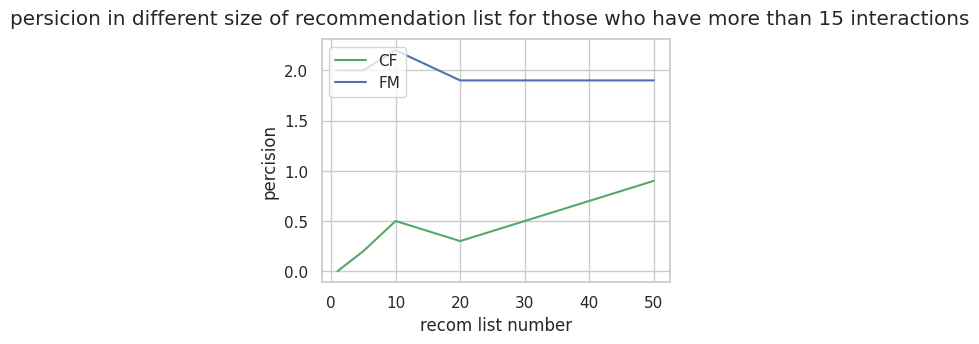

In [102]:
# indicate the effect of size of recommendation list for CF(collaborative Filtering) and FM(Light FM)
rcParams['figure.figsize'] = 4, 3

x = [1,  5,    10,  20,     50]
CF =[0,  0.2,  0.5, 0.3,   0.9]
FM =[2,  2,    2.2,  1.9,  1.9]

fig, (ax1) = plt.subplots()

ax1.plot(x, CF, 'g')
ax1.plot(x, FM, 'b')
ax1.set_ylabel('percision')
ax1.set_xlabel('recom list number')
ax1.legend(['CF', 'FM'], loc='upper left')
ax1.grid(True)



fig.suptitle('persicion in different size of recommendation list for those who have more than 15 interactions')
plt.show()


<font size="+2">show the percision for different values of the number of interactions for CF(collaborative Filtering) and FM(Light FM):

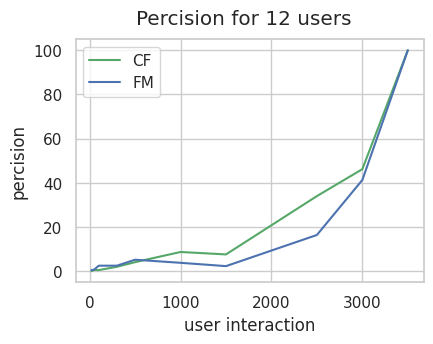

In [103]:
rcParams['figure.figsize'] = 4, 3

x = [20,  50,   100,   300, 500,  1000, 1500,  2500,  3000,  3500]
CF = [0,  0.6,  0.5,   2,   4.1,  8.7,  7.6,   34,    46.2,  100]
FM = [.5, 0.7,  2.5,   2.5, 5.2,  3.8,  2.3,   16.4,  41.3,  100]

fig, (ax1) = plt.subplots()

ax1.plot(x, CF, 'g')
ax1.plot(x, FM, 'b')
ax1.set_ylabel('percision')
ax1.set_xlabel('user interaction')
ax1.legend(['CF', 'FM'], loc='upper left')
ax1.grid(True)


fig.suptitle('Percision for 12 users')
plt.show()


<font size="+2"> show the imapact of different values of the number of interactions in recall for CF(collaborative Filtering) and FM(Light FM) models:


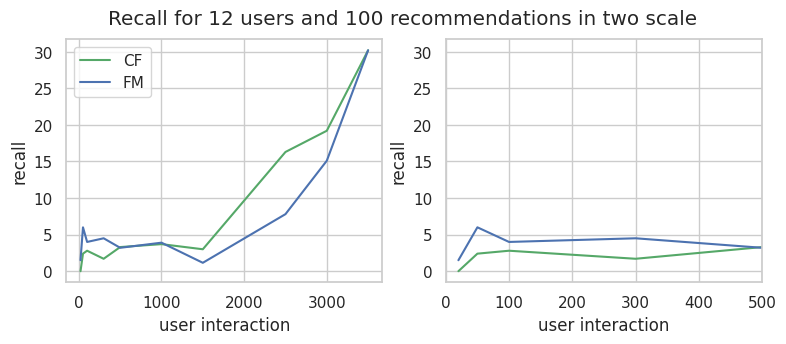

In [104]:
rcParams['figure.figsize'] = 4, 3

x = [20,   50,   100,  300,  500, 1000,  1500, 2500,   3000, 3500]
CF = [0,   2.4,  2.8,  1.7,  3.3, 3.7,   3,    16.3,   19.2, 30.2]
FM = [1.5, 6,    4,    4.5,  3.2, 3.9,   1.15,  7.8,   15.1, 30.2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(x, CF, 'g')
ax1.plot(x, FM, 'b')
#ax1.set_title('for 12 user and 100 recomend')
ax1.set_ylabel('recall')
ax1.set_xlabel('user interaction')
ax2.set_xlim(0, 3500)
ax1.grid(True)
ax1.legend(['CF', 'FM'], loc='upper left')

ax2.plot(x, CF, 'g')
ax2.plot(x, FM, 'b')
ax2.set_ylabel('recall')
ax2.set_xlabel('user interaction')
ax2.set_xlim(0, 500)
ax2.grid(True)
ax1.legend(['CF', 'FM'], loc='upper left')

fig.suptitle('Recall for 12 users and 100 recommendations in two scale')
plt.show()

<font size="+2"><b>comparison between the RMSE and (recall,percision):</b><br>
 <br>
<font size="+1"> RSME is not a good metric for user-item rating in this systems,<br> 
 because when we run the model,at a low number of interactions such as 10, RMSE will be minimised<br> 
 but its percision and recall are almost zero thus,<br>
 we should use recall and percision for our evaluation<br>
<br>
to demonstrate that, if you have enough time you can run the following code to see the RMSE, Recall and Percision at a low number of interactions:<br>
    
    time taken for following cell: <b>4.5 min</b>
    

In [105]:
# RMSE, History, model ,test ,n_interaction = cf_model(df1,n_interaction=9 ,batch_size=1024,epochs=20,n_latent_factors=65,  verbose=1,rating= rating ,optimizer=Adagrad(learning_rate=12) )
# ploting_loss(History, n_interaction, RMSE)
# evaluate_CF(user_size=20, n_recom_items=100)